In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle
from scf_impute import analysis_variables, scoring, impute, master
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy import stats
import matplotlib
import missingno as msno
%matplotlib inline

In [2]:
DATA_FOLDER = 'data'

In [40]:
dct_param = {'data': os.path.join('..', 'data'),
             'missing_val': 'nan'}
with open(os.path.join(DATA_FOLDER, 'variables-xgboost-new.pickle'), 'rb') as handle:
        dct_data = pickle.load(handle)

# Missing patterns exploration

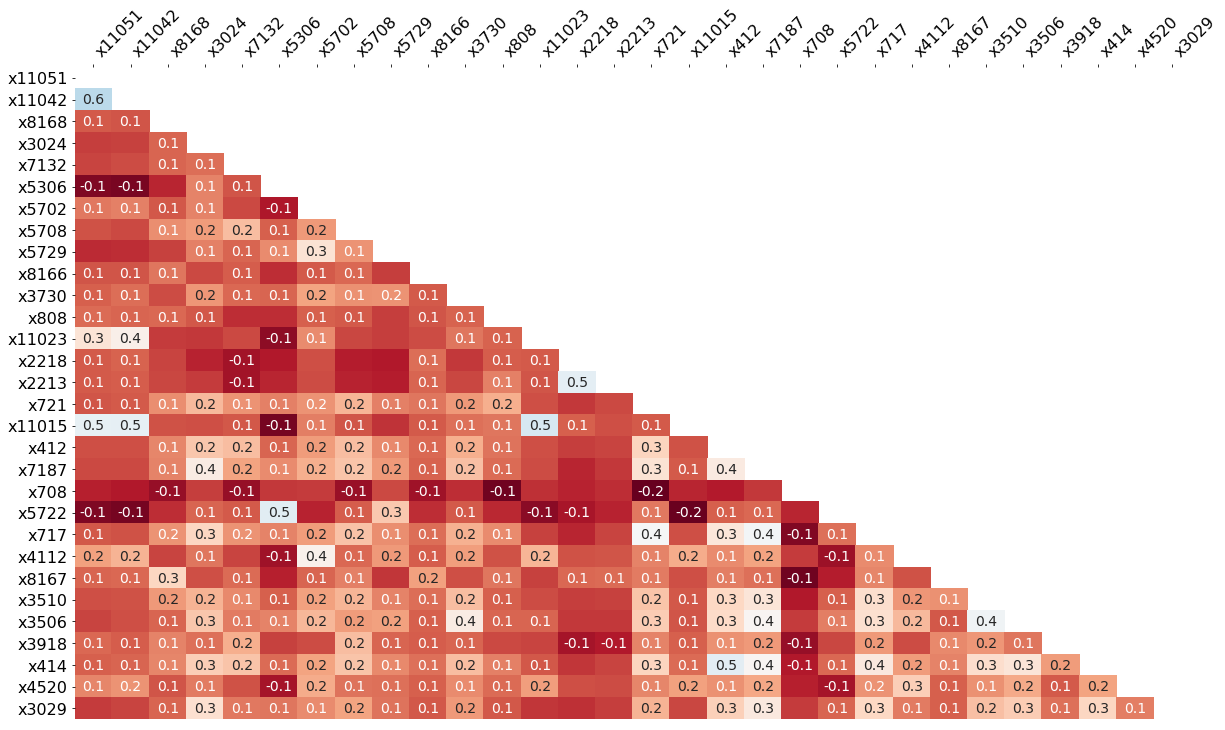

In [52]:
df_raw_data = dct_data['df_orig_data']
cols = dct_data['lst_num_cols'] + dct_data['lst_year_cols'] + dct_data['lst_char_cols'] + dct_data['lst_skipped_cols'] + dct_data['empty_cols']
df_raw_data = df_raw_data[list(set(cols))]
filtered_data = msno.nullity_filter(df_raw_data, filter='bottom', n=50, p=0.9)
msno.heatmap(filtered_data)

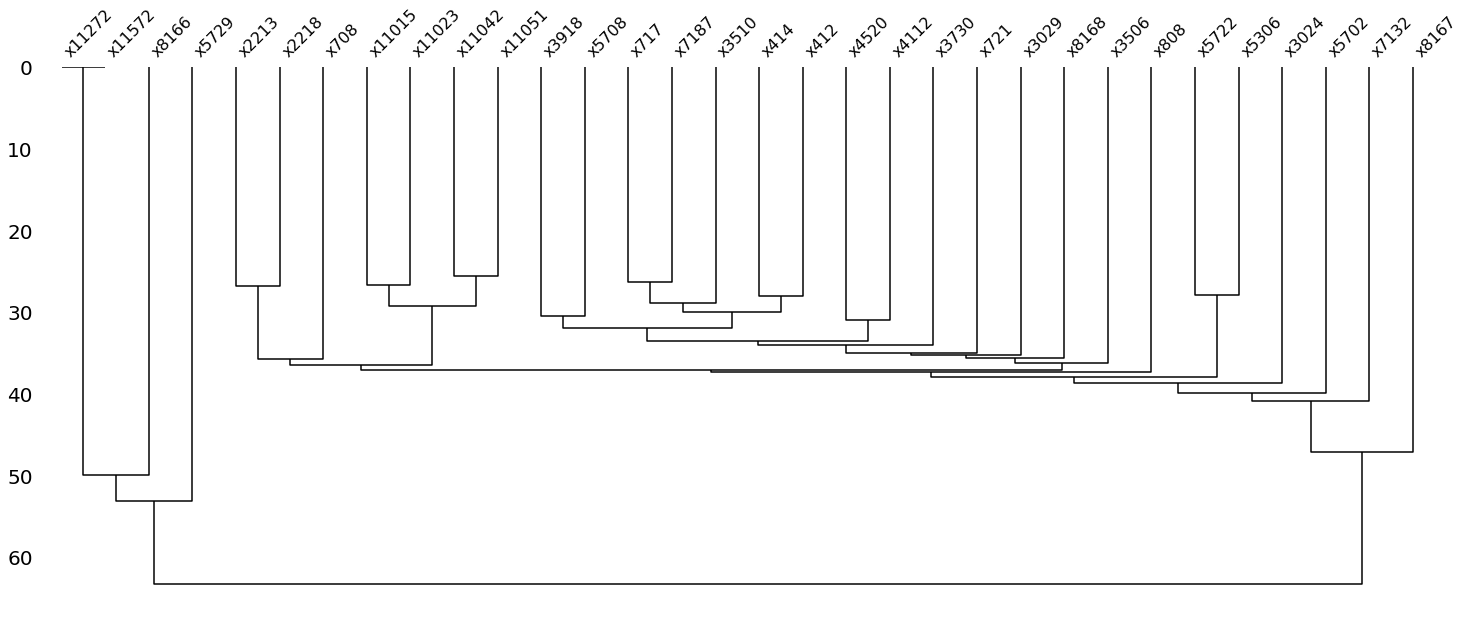

In [53]:
filtered_data = msno.nullity_filter(df_raw_data, filter='bottom', p=0.9)
msno.dendrogram(filtered_data)

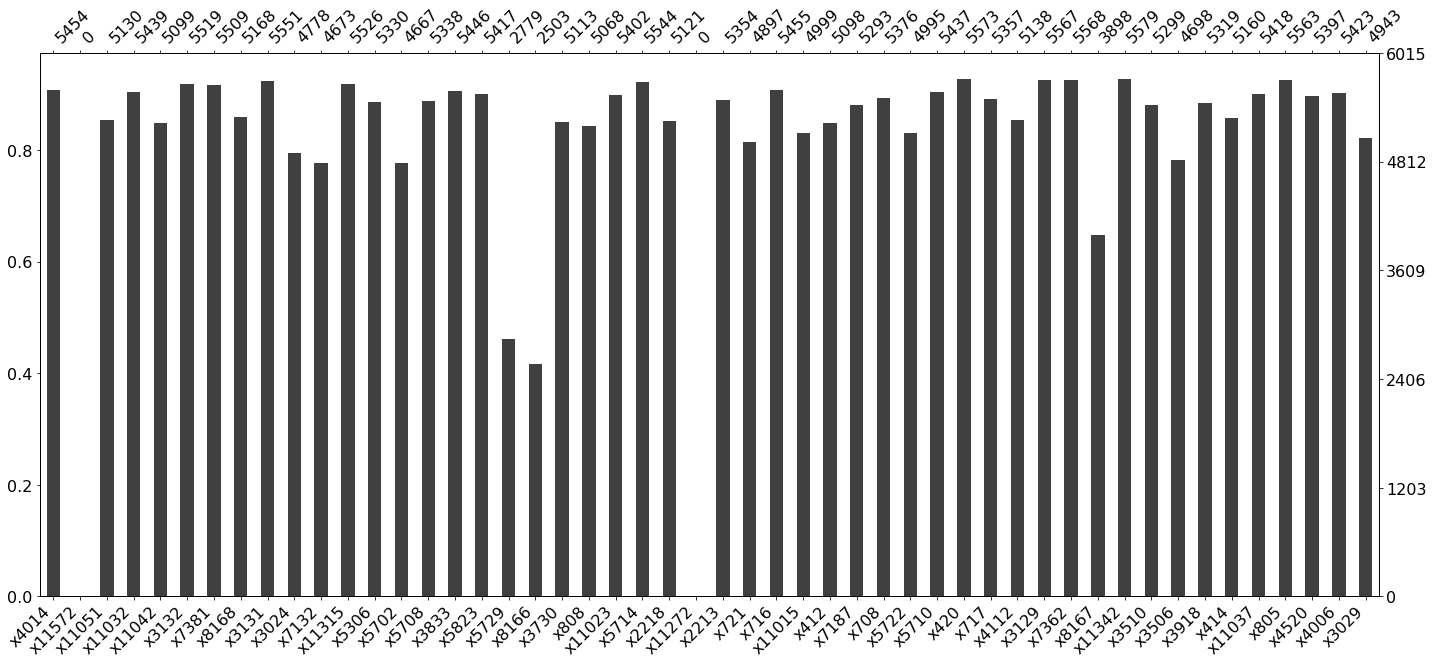

In [58]:
filtered_data = msno.nullity_filter(df_raw_data, filter='bottom', n=50, p=0.99)
filtered_data = msno.nullity_sort(filtered_data, sort='descending')
msno.bar(filtered_data)

# Prepare full data

In [4]:
df_xgboost_full = scoring.prepare_for_scores(dct_data, dict(), dct_data['xgboost_imputed_100'], 100, with_impute=False)

In [6]:
df_knn_full = scoring.prepare_for_scores(dct_data, dict(), pd.read_csv('data/knn_imputed_100.csv', index_col=0), 100, with_impute=False)

In [7]:
df_missforest_full = scoring.prepare_for_scores(dct_data, dict(), pd.read_csv('data/missforest_imputed_100.csv', index_col=0), 100, with_impute=False)

In [8]:
df_xgboost_full.to_csv('data/xgboost_imputed_full.csv', index=True)
df_knn_full.to_csv('data/xgboost_knn_full.csv', index=True)
df_missforest_full.to_csv('data/xgboost_missforest_full.csv', index=True)

# Accuracy Scores

## xGBoost

In [41]:
y_num = pd.DataFrame(columns=('imputed', 'actual', 'row', 'col'))
y_char = pd.DataFrame(columns=['actual', 'imputed', 'col'])
for i in range(1,6):
    df_imputed = dct_data['xgboost_imputed_raw' + str(i)].copy()
    df_imputed = master.prepare_for_upload(dct_data, df_imputed)
    nums, mse = scoring.get_mse(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_num_cols'], dct_data['df_removed_'+str(i)])
    y_num = y_num.append(nums)
    chars, m_accuracy = scoring.get_accuracy(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_char_cols'], dct_data['df_removed_'+str(i)])
    y_char = y_char.append(chars)

pd.DataFrame({'m_rmse': mean_squared_error(y_num['actual'], y_num['imputed']),
              'm_accuracy': accuracy_score(y_char['actual'], y_char['imputed'])
             }, index=[0])

,m_accuracy,m_rmse
0,0.70184,5.124826


## kNN

In [34]:
y_num = pd.DataFrame(columns=('imputed', 'actual', 'row', 'col'))
y_char = pd.DataFrame(columns=['actual', 'imputed', 'col'])
for i in range(1,6):
    
    df_imputed = pd.read_csv('data/knn_imputed_' + str(i) + '.csv', index_col=0)
    df_imputed = master.prepare_for_upload(dct_data, df_imputed)
    nums, mse = scoring.get_mse(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_num_cols'], pd.read_csv('data/withheld_' + str(i) + '.csv', index_col=0))
    
    y_num = y_num.append(nums)
    chars, m_accuracy = scoring.get_accuracy(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_char_cols'], pd.read_csv('data/withheld_' + str(i) + '.csv', index_col=0))
    
    y_char = y_char.append(chars)
    

pd.DataFrame({'m_rmse': mean_squared_error(y_num['actual'], y_num['imputed']),
              'm_accuracy': accuracy_score(y_char['actual'], y_char['imputed'])
             }, index=[0])

,m_accuracy,m_rmse
0,0.729543,7.887496


## missForest

In [148]:
y_num = pd.DataFrame(columns=('imputed', 'actual', 'row', 'col'))
y_char = pd.DataFrame(columns=['actual', 'imputed', 'col'])
for i in range(1,5):
    df_imputed = pd.read_csv('data/missforest_imputed_' + str(i) + '.csv', index_col=0)
    df_imputed = master.prepare_for_upload(dct_data, pd.read_csv('data/missforest_imputed_' + str(1) + '.csv', index_col=0))
    nums, mse = scoring.get_mse(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_num_cols'], pd.read_csv('data/withheld_' + str(i) + '.csv', index_col=0))
    y_num = y_num.append(nums)
    chars, m_accuracy = scoring.get_accuracy(dct_data['df_full_cleaned_data'].copy(), df_imputed, dct_data['lst_char_cols'], pd.read_csv('data/withheld_' + str(i) + '.csv', index_col=0))
    y_char = y_char.append(chars)

pd.DataFrame({'m_rmse': mean_squared_error(y_num['actual'], y_num['imputed']),
              'm_accuracy': accuracy_score(y_char['actual'], y_char['imputed'])
             }, index=[0])

,m_accuracy,m_rmse
0,0.979736,0.998144


# Withholding model results

In [45]:
df_missing_probabilities = pd.read_csv(os.path.join('data', 'missing_probabilities.csv'), index_col=0)
df_missing_indicators = pd.read_csv(os.path.join('data', 'missing_indicator.csv'),
                                                       index_col=0)
df_full_data = dct_data['df_full_cleaned_data'].copy()

In [57]:
for col in df_full_data.columns:
    df_full_data[col+'_missing_indicator'] = df_missing_indicators[col]

## x5729 -Total Income

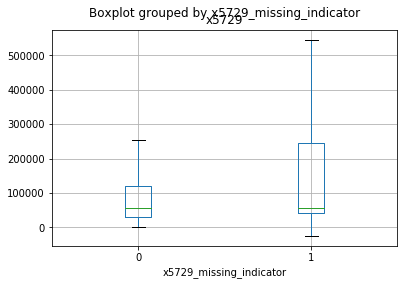

In [70]:
df_full_data[df_full_data['x5729'].notnull()].boxplot(column='x5729', by='x5729_missing_indicator', showfliers=False)

## x8166 - Retail value of vehicle

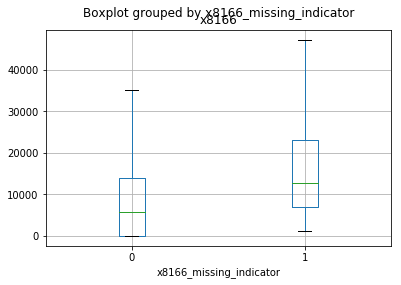

In [72]:
df_full_data[df_full_data['x8166'].notnull()].boxplot(column='x8166', by='x8166_missing_indicator', showfliers=False)

## x5702 - Total Income from wages

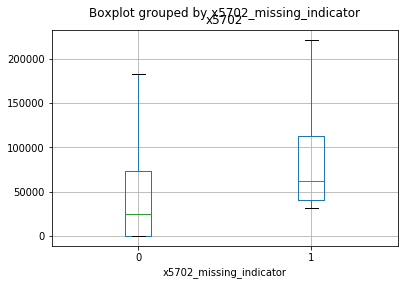

In [75]:
df_full_data[df_full_data['x5702'].notnull()].boxplot(column='x5702', by='x5702_missing_indicator', showfliers=False)

## x7132 card interest rate

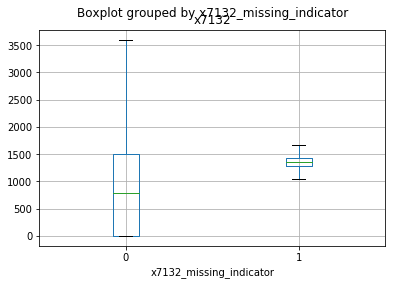

In [80]:
df_full_data[df_full_data['x7132'].notnull()].boxplot(column='x7132', by='x7132_missing_indicator', showfliers=False)

## x808 Land Contract payments

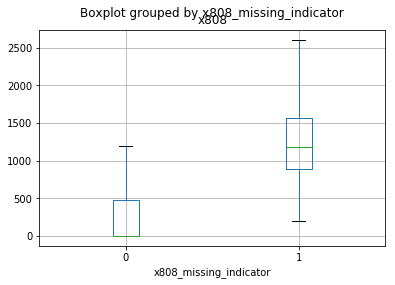

In [82]:
df_full_data[df_full_data['x808'].notnull()].boxplot(column='x808', by='x808_missing_indicator', showfliers=False)

## x721 Real Estate Taxes

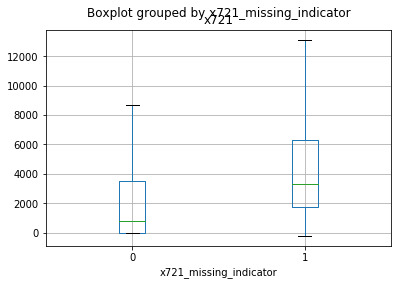

In [83]:
df_full_data[df_full_data['x721'].notnull()].boxplot(column='x721', by='x721_missing_indicator', showfliers=False)

## x717 Purchase price of property owned

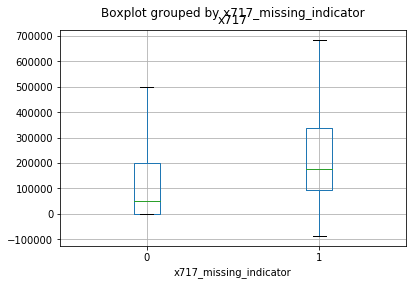

In [84]:
df_full_data[df_full_data['x717'].notnull()].boxplot(column='x717', by='x717_missing_indicator', showfliers=False)

## x3730 Amount in savings account

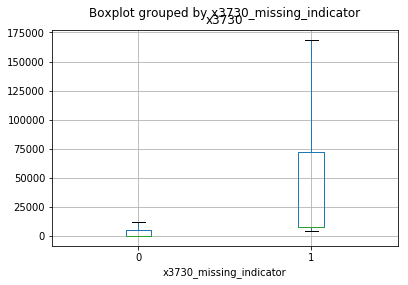

In [87]:
df_full_data[df_full_data['x3730'].notnull()].boxplot(column='x3730', by='x3730_missing_indicator', showfliers=False)

## x3510 Amount in checking account

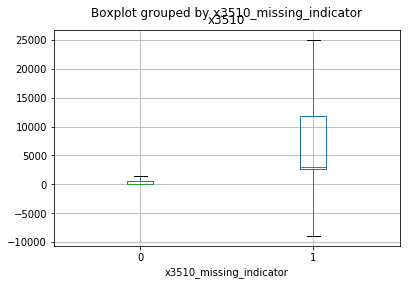

In [92]:
df_full_data[df_full_data['x3510'].notnull()].boxplot(column='x3510', by='x3510_missing_indicator', showfliers=False)

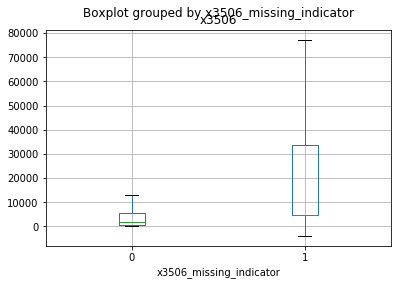

In [96]:
df_full_data[df_full_data['x3506'].notnull()].boxplot(column='x3506', by='x3506_missing_indicator', showfliers=False)

## x414 Total Credit Limit

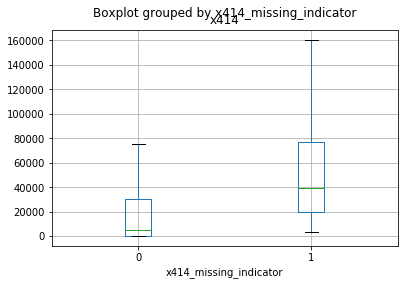

In [101]:
df_full_data[df_full_data['x414'].notnull()].boxplot(column='x414', by='x414_missing_indicator', showfliers=False)

## x412 Credit Card Utilization

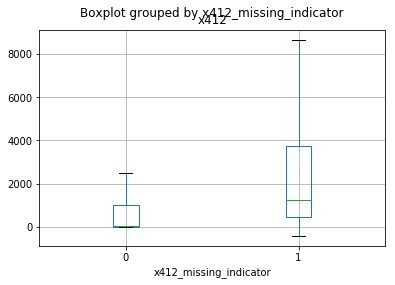

In [104]:
df_full_data[df_full_data['x412'].notnull()].boxplot(column='x412', by='x412_missing_indicator', showfliers=False)

## x4112 Income from main job

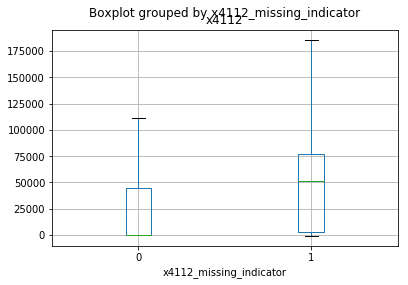

In [105]:
df_full_data[df_full_data['x4112'].notnull()].boxplot(column='x4112', by='x4112_missing_indicator', showfliers=False)

## x716 Current value of home

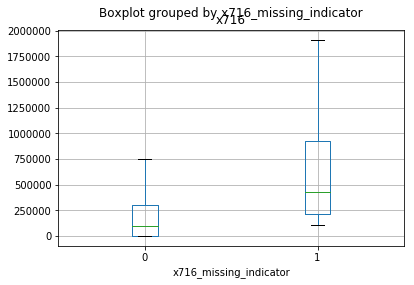

In [113]:
df_full_data[df_full_data['x716'].notnull()].boxplot(column='x716', by='x716_missing_indicator', showfliers=False)

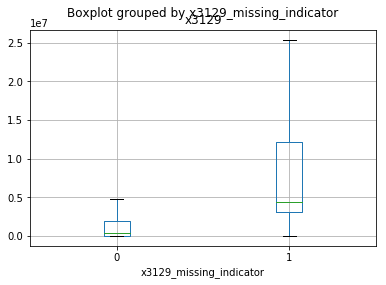

In [147]:
df_full_data[df_full_data['x3129'].notnull() & (df_full_data['x3129'] > 0)].boxplot(column='x3129', by='x3129_missing_indicator', showfliers=False)